# Face Pose Estimator 

In this notebook, we will try to estimate the __pose (roll, pitch and yaw) of a face__:

<img src='images/face_poses.png' width=400>

In order to achieve this task, we're going to use only the pairwise distance between facial landmarks detected by [Dlib library](http://dlib.net):

<img src='images/dlib_landmarks.png' width=350>


## Dependencies 

In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Using TensorFlow backend.


## Data 

For this problem, I created a toy database with __6288 images__. For each image, I detected the facial landmarks with Dlib (68 points) and computed the pairwise euclidean distance between all points. Thus, given 68 points $\{p_1, p_2, ..., p_{68}\}$ where $d(p_i, p_j) = d(p_j, p_i)$ and $d(p_i, p_i) = 0$, we ended up with $\frac{68*67}{2} = 2278$ features. In addition, once we will use Neural Networks to predict roll, pitch, and yaw at the same time, our response variable will have shape 6288x3.

In [2]:
x, y = pkl.load(open('data/samples.pkl', 'rb'))

print(x.shape, y.shape)

(6288, 2278) (6288, 3)


In [3]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197 5.17623111671
-29.88856888 34.09674835 2.58468274027 7.96282815186
-75.55059814 86.84925079 -0.116205880073 13.0908391832


Let's divide you dataset in train, validation, and test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


and normalize it:

In [5]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

## Model

### Hyperparams 

In [6]:
BATCH_SIZE = 64
EPOCHS = 100

### Training

In [7]:
model = Sequential()
model.add(Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))

print(model.summary())

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)
model.save('models/model.h5')

print()
print('Train loss:', model.evaluate(x_train, y_train, verbose=0))
print('  Val loss:', model.evaluate(x_val, y_val, verbose=0))
print(' Test loss:', model.evaluate(x_test, y_test, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                45580     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________
None
Train on 4401 samples, validate on 943 samples
Epoch 1/100
4401/4401 [==============================] - 1s 120us/step - loss: 66.7419 - val_loss: 54.9232
Epoch 2/100
4401/4401 [==============================] - 0s 60us/step - loss: 50.4013 - val_loss: 53.6252
Epoch 3/100
4401/4401 [==============================] - 0s 61us/step - loss: 42.6244 - val_loss: 38.4167
Epoch 4/100
4401/4401 [========

4401/4401 [==============================] - 0s 62us/step - loss: 30.0203 - val_loss: 34.6279
Epoch 71/100
4401/4401 [==============================] - 0s 60us/step - loss: 29.8764 - val_loss: 32.5923
Epoch 72/100
4401/4401 [==============================] - 0s 83us/step - loss: 29.9778 - val_loss: 32.6140
Epoch 73/100
4401/4401 [==============================] - 0s 59us/step - loss: 29.4898 - val_loss: 31.6336
Epoch 74/100
4401/4401 [==============================] - 0s 60us/step - loss: 29.8431 - val_loss: 32.8289
Epoch 75/100
4401/4401 [==============================] - 0s 59us/step - loss: 29.4467 - val_loss: 32.4590
Epoch 76/100
4401/4401 [==============================] - 0s 60us/step - loss: 29.8311 - val_loss: 31.8684
Epoch 77/100
4401/4401 [==============================] - 0s 63us/step - loss: 29.6122 - val_loss: 31.0215
Epoch 78/100
4401/4401 [==============================] - 0s 64us/step - loss: 29.7145 - val_loss: 31.4337
Epoch 79/100
4401/4401 [==========================

As we can see, our model achieved a good result even in testset. Since we are using the MSE as loss function, we can estimate our model has an error of $\pm$6º. You can try improve the model if you want before continuing. 

Let's visualize our training graph:

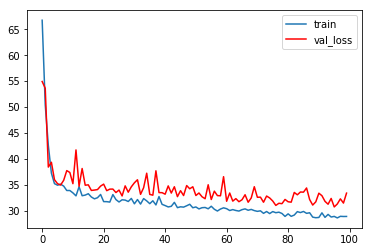

In [8]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()

Good job! Our graph follows the patterns we expect when training deep learning models.

To finish our model analysis, we'll plot the difference between expected and predictions values:

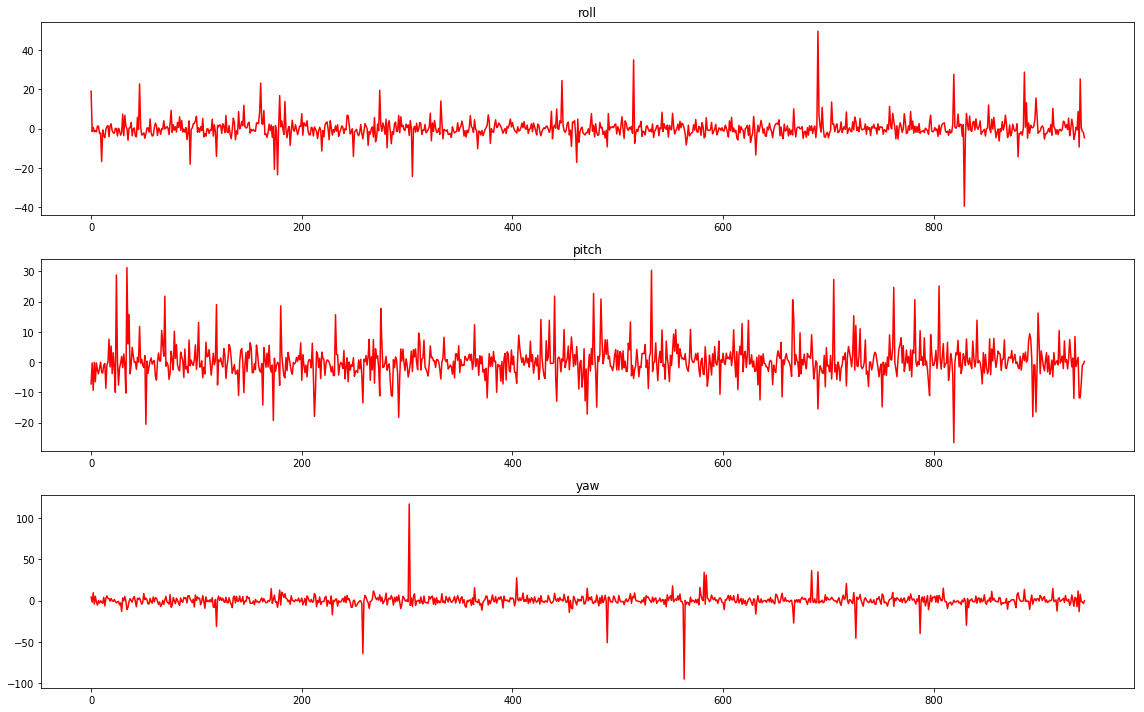

In [9]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()

As we can observe, the yaw was the easiest one to our model predict, followed by roll and pitch, respectively. However, we can observe some outliers in all graphs. We'll let to investigate them as future work. 

### Testing the model 

Now, we will test the model we've just trained. But first, you must have to download the [shape_model](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2) (if you haven't already) to be able to detect the facial landmarks. Download it and extract it in _models_ folder.

In [10]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

If you wanna try it out with your own image, just paste it inside you _data_ folder and change the name in the first line bellow:

 Roll: 0.67°
Pitch: -4.89°
  Yaw: 22.57°


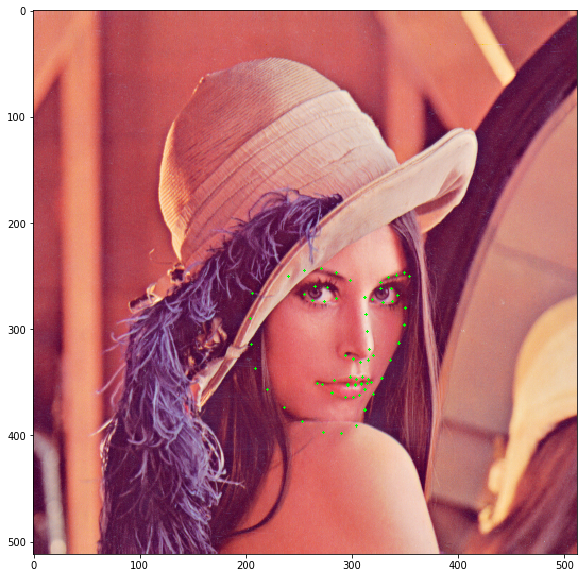

In [11]:
im = cv2.imread('data/lena.png', cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(im)

for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = load_model('models/model.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('  Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)

How well do you think our model is?

## References 

- [Reconhecendo landmarks em faces com dlib + Python](https://medium.com/@suzana.svm/reconhecendo-landmarks-em-faces-com-dlib-python-7bfb094e1bb4)
- [Facial landmarks with dlib, OpenCV, and Python](https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)